#Load Library

In [20]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import PIL
import datetime
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm


from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
import graphviz

from os import system 
import warnings
warnings.filterwarnings(action='ignore') 


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

#import uszipcode
#from uszipcode import SearchEngine, SimpleZipcode, Zipcode

#EDA

In [21]:
df = pd.read_csv("./CABAData_123122 with OPEID8_School Data.csv")

### Check the NA

# def check_missing_col(dataframe):
#     counted_missing_col = 0
#     for i, col in enumerate(dataframe.columns):
#         missing_values = sum(dataframe[col].isna())
#         is_missing = True if missing_values >= 1 else False
#         if is_missing:
#             counted_missing_col += 1
#             print(f'Col name: {col}')
#             print(f'Count NA: {missing_values}')

#         if i == len(dataframe.columns) - 1 and counted_missing_col == 0:
#             print('No missing value')

# check_missing_col(df)

In [22]:
cohort_columns = [("ApprovalFICO", [800, 700, 600], ["800 over", "700-799", "600-699", "600 less"]),
                  ("CurrentInterestRate", [0.1, 0.08, 0.06], ["10% over", "8%-9.9%", "6%-7.9%", "6% less"]),
                  ("StudentAge", [55, 35, 26], ["55 over", "35-54", "26-34", "25 less"])]

for col, thresholds, cohort_labels in cohort_columns:
    def func(x):
        for i, threshold in enumerate(thresholds):
            if x >= threshold:
                return cohort_labels[i]
        return cohort_labels[-1]
    df[col + "_COHORTS"] = df[col].apply(lambda x : func(x))


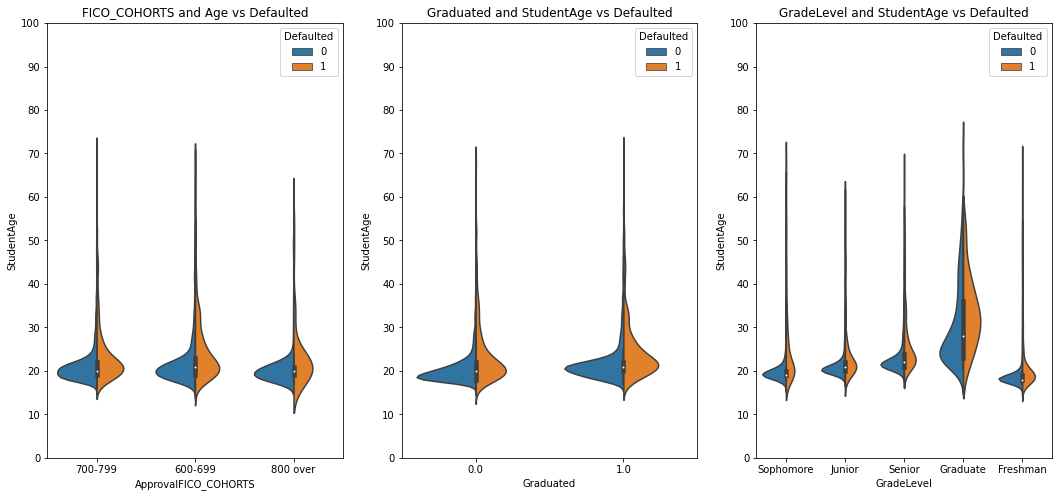

In [23]:
f,ax=plt.subplots(1,3,figsize=(18,8))
sns.violinplot(x="ApprovalFICO_COHORTS", y="StudentAge", hue="Defaulted", data=df,split=True,ax=ax[0])
ax[0].set_title('FICO_COHORTS and Age vs Defaulted')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Graduated", y="StudentAge", hue="Defaulted", data=df,split=True,ax=ax[1])
ax[1].set_title('Graduated and StudentAge vs Defaulted')
ax[1].set_yticks(range(0,110,10))
sns.violinplot(x="GradeLevel", y="StudentAge", hue="Defaulted", data=df,split=True,ax=ax[2])
ax[2].set_title('GradeLevel and StudentAge vs Defaulted')
ax[2].set_yticks(range(0,110,10))
plt.show()

# RF model

## Data selection

In [24]:
encoder = LabelEncoder()
df['AcademicYear_Label'] = encoder.fit_transform(df['AcademicYear'])

# Create pre and post covid dataframes based on AcademicYear_Label
df_precovid = df[df['AcademicYear_Label'] <= 10]
df_postcovid = df[df['AcademicYear_Label'] >= 11]

# Define columns of interest
cols_of_interest = ["BorrowerAge", "StudentAge", "SchoolPaymentType", "GradeLevel", "Cosigned", 
                    "ApprovalFICO", "OriginalLoanAmount", "InterestRateType", "CurrentInterestRate", 
                    "Defaulted", "main_campus", "sat_scores_average_overall"]

df = df[cols_of_interest]
df_precovid = df_precovid[cols_of_interest]
df_postcovid = df_postcovid[cols_of_interest]

## Model build

In [25]:
# Define function to preprocess the data
def preprocess_data(df):
    df.dropna(inplace=True)
    df = pd.get_dummies(df, columns=['SchoolPaymentType', 'GradeLevel', 'InterestRateType'])
    X = df.drop('Defaulted', axis=1)
    y = df['Defaulted']
    oversample = RandomOverSampler(sampling_strategy='all', random_state=42)
    X_over, y_over = oversample.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Train and save the models
models = ['fullperiod', 'precovid', 'postcovid']
for i, data in enumerate([df, df_precovid, df_postcovid]):
    X_train, X_test, y_train, y_test = preprocess_data(data)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, f'rf_model_{models[i]}.joblib')

# Evaluate the models
for i, data in enumerate([df, df_precovid, df_postcovid]):
    X_train, X_test, y_train, y_test = preprocess_data(data)
    model = joblib.load(f'rf_model_{models[i]}.joblib')
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{models[i]} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

fullperiod - Accuracy: 0.9863558840250142, Precision: 0.973568281938326, Recall: 1.0, F1: 0.9866071428571429
precovid - Accuracy: 0.9706178305494063, Precision: 0.9465737514518002, Recall: 0.9967386873216469, F1: 0.971008737092931
postcovid - Accuracy: 0.9985486211901307, Precision: 0.9971401334604385, Recall: 1.0, F1: 0.9985680190930787


In [26]:
# Prepare the dataset
df.dropna(inplace=True) 
df = pd.get_dummies(df, columns=['SchoolPaymentType', 
                                 'GradeLevel', 'InterestRateType', 
                                 ])

# Split the dataset into features and target variable
X = df.drop('Defaulted', axis=1)
y = df['Defaulted']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the random forest model
model_full = RandomForestClassifier(random_state=42)

# Train the model on the training data
model_full.fit(X_train, y_train)


# Define the oversampler
oversample = RandomOverSampler(sampling_strategy='all', random_state=42)

# Apply oversampling to the dataset
X_over, y_over = oversample.fit_resample(X, y)

# Split the oversampled dataset into training and testing sets
X_train, X_test, y_train, y_test_full = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# Train the model on the training data
model_full.fit(X_train, y_train)

# Save the trained model
joblib.dump(model_full, 'random_forest_model_1.joblib')

# Evaluate the performance of the model on the testing data
y_pred_full = model_full.predict(X_test)
accuracy_full = accuracy_score(y_test_full, y_pred_full)
precision_full = precision_score(y_test_full, y_pred_full)
recall_full = recall_score(y_test_full, y_pred_full)
f1_full = f1_score(y_test_full, y_pred_full)


df_precovid.dropna(inplace=True)
df_precovid = pd.get_dummies(df_precovid, columns=['SchoolPaymentType', 
                                 'GradeLevel', 'InterestRateType', 
                                 ])

X = df_precovid.drop('Defaulted', axis=1)
y = df_precovid['Defaulted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pre = RandomForestClassifier(random_state=42)

model_pre.fit(X_train, y_train)
oversample = RandomOverSampler(sampling_strategy='all', random_state=42)
X_over, y_over = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test_pre = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

model_pre.fit(X_train, y_train)

joblib.dump(model_pre, 'random_forest_model_2.joblib')
y_pred_pre = model_pre.predict(X_test)
accuracy_pre = accuracy_score(y_test_pre, y_pred_pre)
precision_pre = precision_score(y_test_pre, y_pred_pre)
recall_pre = recall_score(y_test_pre, y_pred_pre)
f1_pre = f1_score(y_test_pre, y_pred_pre)

df_postcovid.dropna(inplace=True) 
df_postcovid = pd.get_dummies(df_postcovid, columns=['SchoolPaymentType', 
                                 'GradeLevel', 'InterestRateType', 
                                 ])
X = df_postcovid.drop('Defaulted', axis=1)
y = df_postcovid['Defaulted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_post = RandomForestClassifier(random_state=42)
model_post.fit(X_train, y_train)

oversample = RandomOverSampler(sampling_strategy='all', random_state=42)

# Apply oversampling to the dataset
X_over, y_over = oversample.fit_resample(X, y)

# Split the oversampled dataset into training and testing sets
X_train, X_test, y_train, y_test_post = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# Train the model on the training data
model_post.fit(X_train, y_train)

# Save the trained model
joblib.dump(model_post, 'random_forest_model_3.joblib')

# Evaluate the performance of the model on the testing data
y_pred_post = model_post.predict(X_test)
accuracy_post = accuracy_score(y_test_post, y_pred_post)
precision_post = precision_score(y_test_post, y_pred_post)
recall_post = recall_score(y_test_post, y_pred_post)
f1_post = f1_score(y_test_post, y_pred_post)

##Model validation

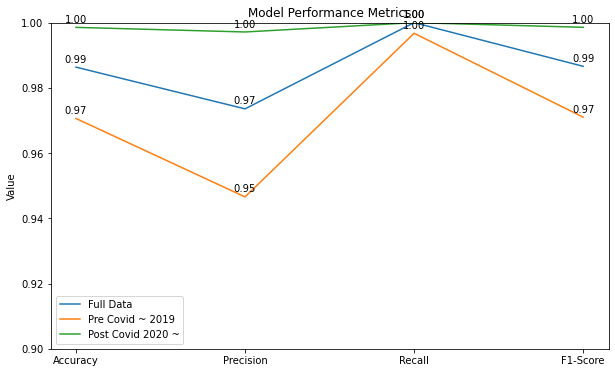

In [27]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values_full = [accuracy_full, precision_full, recall_full, f1_full]
values_pre = [accuracy_pre, precision_pre, recall_pre, f1_pre]
values_post = [accuracy_post, precision_post, recall_post, f1_post]

x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, values_full, label='Full Data')
ax.plot(x, values_pre, label='Pre Covid ~ 2019')
ax.plot(x, values_post, label='Post Covid 2020 ~')


ax.set_title('Model Performance Metrics')
ax.legend()
ax.set_ylim(0.9, 1)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Value')


for values, label in zip([values_full, values_pre, values_post], ['Full Data', 'Pre Covid ~ 2019', 'Post Covid 2020 ~']):
    for i, value in enumerate(values):
        ax.annotate(f'{value:.2f}',
                    xy=(i, value),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.show()

In [28]:
def print_f1_score(y_test, y_pred, label):
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    print(f"{label} data")
    print(f"F1 score for class 0: {f1_class_0}")
    print(f"F1 score for class 1: {f1_class_1}\n")


print_f1_score(y_test_full, y_pred_full, "Full")
print_f1_score(y_test_pre, y_pred_pre, "Pre Covid ~ 2019")
print_f1_score(y_test_post, y_pred_post, "Post Covid 2020 ~")

Full data
F1 score for class 0: 0.9860950173812283
F1 score for class 1: 0.9866071428571429

Pre Covid ~ 2019 data
F1 score for class 0: 0.9702162382700938
F1 score for class 1: 0.971008737092931

Post Covid 2020 ~ data
F1 score for class 0: 0.9985286905345757
F1 score for class 1: 0.9985680190930787



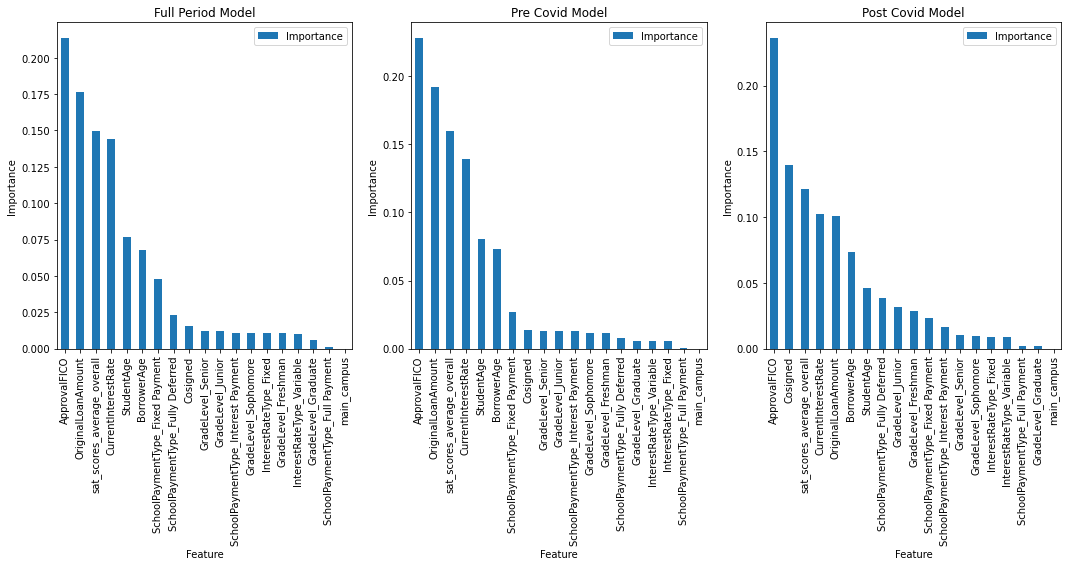

In [29]:
# Get the feature importances for each model
importances_full = model_full.feature_importances_
importances_pre = model_pre.feature_importances_
importances_post = model_post.feature_importances_

# Get the names of the features
features = X_train.columns

# Create a dataframe with the feature importances
df_importances_full = pd.DataFrame({'Feature': features, 'Importance': importances_full})
df_importances_pre = pd.DataFrame({'Feature': features, 'Importance': importances_pre})
df_importances_post = pd.DataFrame({'Feature': features, 'Importance': importances_post})

# Sort the dataframe by importance
df_importances_full = df_importances_full.sort_values(by='Importance', ascending=False).reset_index(drop=True)
df_importances_pre = df_importances_pre.sort_values(by='Importance', ascending=False).reset_index(drop=True)
df_importances_post = df_importances_post.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
df_importances_full.plot.bar(x='Feature', y='Importance', ax=ax1)
ax1.set_title('Full Period Model')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Importance')
df_importances_pre.plot.bar(x='Feature', y='Importance', ax=ax2)
ax2.set_title('Pre Covid Model')
ax2.set_xlabel('Feature')
ax2.set_ylabel('Importance')
df_importances_post.plot.bar(x='Feature', y='Importance', ax=ax3)
ax3.set_title('Post Covid Model')
ax3.set_xlabel('Feature')
ax3.set_ylabel('Importance')

plt.show()

##Predict for new data

In [30]:
# Prepare the new data
new_data = pd.DataFrame({'BorrowerAge': [18],
                         'StudentAge': [18],
                         'Cosigned': [1],
                         'ApprovalFICO': [770],
                         'OriginalLoanAmount': [14000],
                         'CurrentInterestRate': [5.0915],
                         'main_campus': [1],
                         'sat_scores_average_overall': [1100],
                         'GradeLevel_Freshman': [1],
                         'GradeLevel_Junior': [0],
                         'GradeLevel_Senior': [0],
                         'GradeLevel_Sophomore': [0],
                         'GradeLevel_Graduate': [0],
                         'SchoolPaymentType_Fixed Payment': [1],
                         'SchoolPaymentType_Full Payment': [0],
                         'SchoolPaymentType_Fully Deferred': [0],
                         'SchoolPaymentType_Interest Payment': [0],
                         'InterestRateType_Fixed': [1],
                         'InterestRateType_Variable': [0]
                        })

# Reorder the columns to match the order in the training data
new_data = new_data.reindex(columns=model_full.feature_names_in_)

In [31]:
models = [model_full, model_pre, model_post]
names = ["Model Full data", "Model Pre Covid ~ 2019", "Model Post Covid 2020~"]

for i, model in enumerate(models):
  probs = model.predict_proba(new_data)
  print(names[i] + ":")
  print(f"Defaulted=0: {probs[0][0]:.4f}")
  print(f"Defaulted=1: {probs[0][1]:.4f}\n")

Model Full data:
Defaulted=0: 0.3100
Defaulted=1: 0.6900

Model Pre Covid ~ 2019:
Defaulted=0: 0.2700
Defaulted=1: 0.7300

Model Post Covid 2020~:
Defaulted=0: 0.9900
Defaulted=1: 0.0100



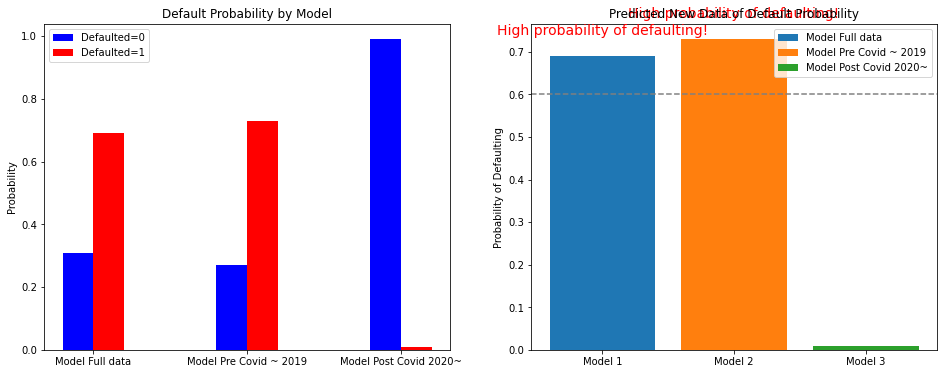

In [32]:
probs_list = []
for model in models:
    probs = model.predict_proba(new_data)[0]
    probs_list.append(probs)

N = len(names)
ind = np.arange(N)
width = 0.2

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  


rects1 = axs[0].bar(ind, [probs[0] for probs in probs_list], width, color='b')
rects2 = axs[0].bar(ind + width, [probs[1] for probs in probs_list], width, color='r')
axs[0].set_ylabel('Probability')
axs[0].set_title('Default Probability by Model')
axs[0].set_xticks(ind + width / 2)
axs[0].set_xticklabels(names)
axs[0].legend((rects1[0], rects2[0]), ('Defaulted=0', 'Defaulted=1'))


threshold = 0.6
labels = ['Model 1', 'Model 2', 'Model 3']
for i, (model, name) in enumerate(zip(models, names)):
    probs = model.predict_proba(new_data)[0]
    if probs[1] > threshold:
        axs[1].text(i, probs[1] + 0.05, "High probability of defaulting!", ha='center', fontsize=14, color='red')
    axs[1].bar(i, probs[1], label=name)

axs[1].set_ylabel('Probability of Defaulting')
axs[1].set_title('Predicted New Data of Default Probability')
axs[1].set_xticks(np.arange(len(labels)))
axs[1].set_xticklabels(labels)
axs[1].legend()
axs[1].axhline(threshold, color='gray', linestyle='--')
if probs[1] > threshold:
    axs[1].text(0.5, 0.95, "High probability of defaulting!", ha='center', va='center', transform=axs[1].transAxes, color='red', fontsize=14)

plt.show()
